# Sparkify Project Workspace
This workspace uses a [subset]('data/mini_sparkify_event_data.json') (128MB) of the full dataset available (12GB). Within this workspace we will create and evaluate different versions of a model to predict user churns. The best resulting model will then be used to evaluate on a larger dataset within IBM cloud.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window, Column
from pyspark.sql.functions import  asc, desc, udf, col, lit, first, max
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import year, month, dayofmonth, concat_ws, count
from pyspark.sql.functions import max, when
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import  VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,\
    GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline



import datetime
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()


your 131072x1 screen size is bogus. expect trouble
23/10/24 11:32:27 WARN Utils: Your hostname, Pinocchio resolves to a loopback address: 127.0.1.1; using 172.18.43.111 instead (on interface eth0)
23/10/24 11:32:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/24 11:32:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load Dataset

In [3]:

sparkify_data = 'data/mini_sparkify_event_data.json'

In [4]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
DF_COUNT = df.count()
DF_COUNT

286500

### Clean Dataset
first check how the data looks like

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
df.describe().show()

23/10/24 11:32:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

We will need userId, sessionId and also page (representing our events) for all further evaluations, so let us first check and clean on them.
#### Clean on userId, page and sessionId

In [9]:
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId", "page"])

In [10]:
df_clean.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [11]:
df_clean.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [12]:
df_clean.select("userId").dropDuplicates().sort(desc("userId")).show(5)

+------+
|userId|
+------+
|    99|
|    98|
|    97|
|    96|
|    95|
+------+
only showing top 5 rows



So we have some userIds which contain only empty string. What about the sessionIds?

In [13]:
df_clean.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [14]:
df_clean.select("sessionId").dropDuplicates().sort("sessionId").show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [15]:
df_clean.select("sessionId").dropDuplicates().sort(desc("sessionId")).show(5)

+---------+
|sessionId|
+---------+
|     2474|
|     2464|
|     2459|
|     2451|
|     2446|
+---------+
only showing top 5 rows



In this dataset we obviously have perfect sessionId data. We have however to clean up on the userId.

In [16]:
df_clean = df_clean.filter(df_clean["userId"] != "")

In [17]:
df_clean.count()

278154

#### Function to clean the dataset

In [18]:
def clean_data(df):
    '''Removes rows with no usable userId, sessionId or page.
    
        Args:
            df: a Pyspark dataframe
            
        Returns:
            df with unusable rows removed
    '''
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId", "page"])
    df_clean = df_clean.filter(df_clean["userId"] != "")
    return df_clean

# Exploratory Data Analysis
Define additional attributes to show downgrades and churns. Also add an attribute phase to be able to follow the user lifecycle. These attributes are used to get a better understanding of the data. 

## Pages
How many different pages do we have within the data?

In [19]:
df_clean.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



We will recognize downgrade events on the "Submit Downgrade" page.
An actual churn is recognized on the "Cancellation Confirmed" page.


In [20]:
DOWNGRADE_EVENT = 'Submit Downgrade'
CHURN_EVENT = 'Cancellation Confirmation'

## User lifecycle
How does the lifecycle of a user look like?

In [21]:
df_clean.select(["userId", "firstname", "page", "song"]).where(df_clean.userId == "99").collect()

[Row(userId='99', firstname='Madison', page='Home', song=None),
 Row(userId='99', firstname='Madison', page='NextSong', song='Welcome (Album Version)'),
 Row(userId='99', firstname='Madison', page='NextSong', song='Si No Existo (Live)'),
 Row(userId='99', firstname='Madison', page='NextSong', song='Moments with Oliver'),
 Row(userId='99', firstname='Madison', page='NextSong', song='Si Do Mhaimeo I'),
 Row(userId='99', firstname='Madison', page='Thumbs Down', song=None),
 Row(userId='99', firstname='Madison', page='NextSong', song='Coleccionista De Canciones'),
 Row(userId='99', firstname='Madison', page='Roll Advert', song=None),
 Row(userId='99', firstname='Madison', page='NextSong', song='Opposite Of Adults'),
 Row(userId='99', firstname='Madison', page='Thumbs Up', song=None),
 Row(userId='99', firstname='Madison', page='NextSong', song='PrÃ\x83Âªte A Porter'),
 Row(userId='99', firstname='Madison', page='NextSong', song='Freedom'),
 Row(userId='99', firstname='Madison', page='NextS

## Downgrades by Hour
Let's have a look at how many downgrades we have per hour.

In [22]:
# user defined function to calculate hour from timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [23]:

def page_access_per_hour(df, page: str):
    '''Plots statistics about visits of page per hour
    
        Args:
            df: a Pyspark dataframe
            page: value representing an event like 'Add to playlist' or "NextSong"
            
        Returns:
            nothing, prints and plots some statistics
    '''
 
    page_in_hour = df.filter(df.page == page).groupby(df.hour).count().orderBy(df.hour.cast("float"))
    print('#####################################################################')
    print(f'# Visits to "{page}" in hour')
    print('#####################################################################')
    page_in_hour.show(24)
    
    # now plot this
    page_in_hour_pd = page_in_hour.toPandas()
    page_in_hour_pd["hour"] = pd.to_numeric(page_in_hour_pd["hour"])
    page_in_hour_pd["count"] = pd.to_numeric(page_in_hour_pd["count"])
    plt.scatter(page_in_hour_pd["hour"], page_in_hour_pd["count"])
    plt.xlim(-1, 24);
    plt.ylim(0, int(1.2 * page_in_hour_pd["count"].max()))
    plt.xlabel("Hour")
    plt.ylabel(f'visits to {page}');
    


In [24]:
# Add hour col to dataset
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

#####################################################################
# Visits to "Submit Downgrade" in hour
#####################################################################
+----+-----+
|hour|count|
+----+-----+
|   0|    1|
|   1|    2|
|   2|    1|
|   5|    3|
|   6|    3|
|   7|    1|
|   8|    2|
|   9|    5|
|  11|    2|
|  12|    2|
|  13|    3|
|  14|    7|
|  15|    5|
|  16|    1|
|  17|    4|
|  18|    4|
|  19|    3|
|  20|    3|
|  21|    4|
|  22|    4|
|  23|    3|
+----+-----+



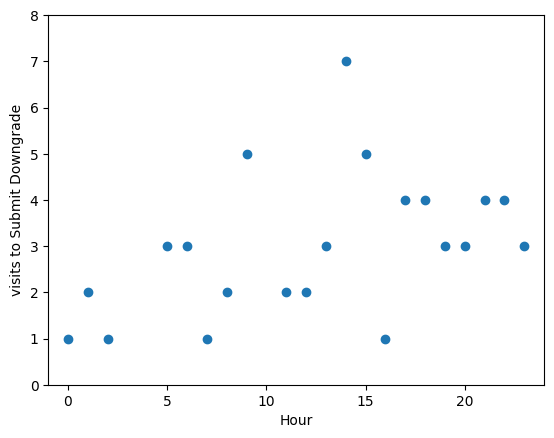

In [25]:
page_access_per_hour(df_clean, DOWNGRADE_EVENT)

## Cancellation Confirmations by Hour
Let's have a look at how cancellations are confirmed per hour.

#####################################################################
# Visits to "Cancellation Confirmation" in hour
#####################################################################
+----+-----+
|hour|count|
+----+-----+
|   0|    2|
|   1|    2|
|   2|    3|
|   4|    1|
|   5|    3|
|   6|    2|
|   8|    2|
|   9|    5|
|  11|    1|
|  12|    2|
|  13|    1|
|  14|    2|
|  15|    1|
|  16|    1|
|  17|    5|
|  18|    2|
|  19|    3|
|  20|    5|
|  21|    3|
|  22|    3|
|  23|    3|
+----+-----+



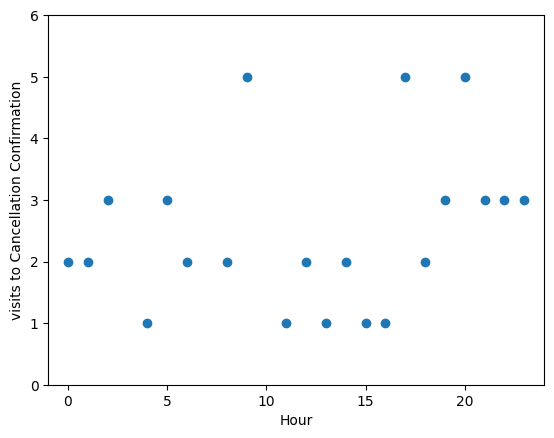

In [26]:
page_access_per_hour(df_clean, CHURN_EVENT)

## Songs played by Hour
Let's have a look at how many songs we have per hour.


#####################################################################
# Visits to "NextSong" in hour
#####################################################################
+----+-----+
|hour|count|
+----+-----+
|   0| 9908|
|   1| 9327|
|   2| 8895|
|   3| 8339|
|   4| 8359|
|   5| 8229|
|   6| 7979|
|   7| 8114|
|   8| 8119|
|   9| 8225|
|  10| 8359|
|  11| 8602|
|  12| 8653|
|  13| 9225|
|  14| 9479|
|  15|10047|
|  16|11036|
|  17|11381|
|  18|11568|
|  19|11346|
|  20|10940|
|  21|10893|
|  22|10823|
|  23|10262|
+----+-----+



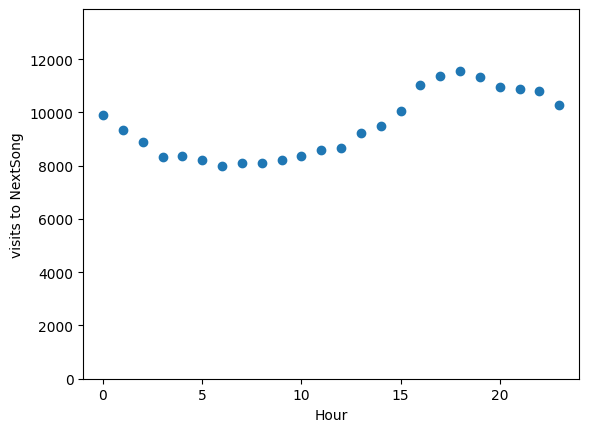

In [27]:
page_access_per_hour(df_clean, 'NextSong')

## Downgrade and Churn
Let's add additional columns to our dataset describing the downgrade "Submit Downgrade" and churn "Cancellation Confirmation" events. We are interested in the following events.

In [28]:
events = [DOWNGRADE_EVENT, CHURN_EVENT]
for event in events:
    print('############################################################')
    print(f'# {event} event')
    print('############################################################')
    df_clean.filter(f"page = '{event}'").show()

############################################################
# Submit Downgrade event
############################################################
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  13|
|  null|Logged In|   Calvin|     M|           17|

Now we will add flags to these.

In [29]:
# udfs to return the flag
flag_downgrade_event = udf(lambda x: 1 if x == DOWNGRADE_EVENT else 0, IntegerType())
flag_churn_event = udf(lambda x: 2 if x == CHURN_EVENT else 0, IntegerType())

In [30]:
# add the columns for the flags
enhanced_df = df_clean.withColumn("downgraded", flag_downgrade_event("page")).\
withColumn("churned", flag_churn_event("page"))

In [31]:
enhanced_df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', downgraded=0, churned=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', hour='2', downgraded=0, churned=0),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSes

#### Plausibility check of the flags
Let us have a look at one user who downgraded and cancelled the subscription. Does the data with the added flags look fine?
To check this we will also introduce an addition "phase" column and use a window partitioned by"userId" and sorted by timestamp "ts"

In [32]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# thisline of code is creating a window specification for a PySpark program. 
# This window specification defines a window that is partitioned by the "userId" column, 
#   ordered within each partition by the "ts" column in descending order, 
#   and includes all rows from the start of the partition up to and including the current row.

In [33]:
# user_log_valid = enhanced_df.withColumn("phase", Fsum("churned").over(windowval))
enhanced_df = enhanced_df.withColumn("phase", Fsum(col("downgraded")).over(windowval) + Fsum(col("churned")).over(windowval))

In [34]:
# chech this for one user
filtered_df = enhanced_df.select(["userId", "firstname", "ts", "page", "level", "downgraded", "churned", "phase"]).where(enhanced_df.userId == "103").sort("ts")
# filtered_df.collect()

In [35]:
# Write the DataFrame to a CSV file
# filtered_df.write.json("filtered_df.json")

We can see, we have now three phases visible within our data. 
* Phase 0: user is not downgraded
* Phase 1: user downgraded
* Phase 3: user churned

```
{"userId":"103","firstname":"Piper","ts":1538648520000,"page":"NextSong","level":"free","downgraded":0,"churned":0,"phase":0}
{"userId":"103","firstname":"Piper","ts":1538648521000,"page":"Thumbs Up","level":"free","downgraded":0,"churned":0,"phase":0}
{"userId":"103","firstname":"Piper","ts":1538648734000,"page":"NextSong","level":"free","downgraded":0,"churned":0,"phase":0}
...
{"userId":"103","firstname":"Piper","ts":1539647784000,"page":"Downgrade","level":"paid","downgraded":0,"churned":0,"phase":0}
{"userId":"103","firstname":"Piper","ts":1539647785000,"page":"Submit Downgrade","level":"paid","downgraded":1,"churned":0,"phase":1}
{"userId":"103","firstname":"Piper","ts":1539647788000,"page":"Home","level":"free","downgraded":0,"churned":0,"phase":1}
...
{"userId":"103","firstname":"Piper","ts":1541340075000,"page":"Downgrade","level":"paid","downgraded":0,"churned":0,"phase":1}
{"userId":"103","firstname":"Piper","ts":1541340076000,"page":"Cancel","level":"paid","downgraded":0,"churned":0,"phase":1}
{"userId":"103","firstname":"Piper","ts":1541340091000,"page":"Cancellation Confirmation","level":"paid","downgraded":0,"churned":2,"phase":3}
```

Complete data for this user can be seen [here](data/filtered_df.json/part-00000-c95a20b0-3e35-4723-b063-0ec6a4313dd7-c000.json). 

#### Function to add churn and downgrade cols to the dataset

In [36]:
def add_churn_and_downgrade_and_phase_cols(df):
    '''Adds additional columns for downgrade and churn events and also the phase in user lifecyle to our dataset
    
        Args:
            df: a Pyspark dataframe
            
        Returns:
            same df but with three additional columns for downgraded, churned and phase
    '''
    # udfs to return the flags for downgrade and chunk
    flag_downgrade_event = udf(lambda x: 1 if x == DOWNGRADE_EVENT else 0, IntegerType())
    flag_churn_event = udf(lambda x: 2 if x == CHURN_EVENT else 0, IntegerType())

    # add downgraded and churned columns
    enhanced_df = df.withColumn("downgraded", flag_downgrade_event("page")).\
    withColumn("churned", flag_churn_event("page"))

    # add also phase column
    windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    # user_log_valid = enhanced_df.withColumn("phase", Fsum("churned").over(windowval))
    enhanced_df = enhanced_df.withColumn("phase", Fsum(col("downgraded")).over(windowval) + Fsum(col("churned")).over(windowval))

    return enhanced_df
    

# Feature Engineering

We will use some of the attributes from the original dataset as well as newly constructed features.

Features from the dataset which might have an impact on quitting behavior might be:
* gender - maybe male users are more likely to quit (or maybe female)?
* location - maybe rural users are more likely to quit?

Additional features that could be derived from the dataset and might be useful:
* usage of playlists - are users with only few playlists/playlist entries more likely to quit?
* number of friends added - are users with more friends less likely to quit?
* songs per day - users which use the service more frequently might be less likely to quit 



## Categorical features from original dataset

In [37]:
result_df = enhanced_df.select("userId", "gender", "location").distinct()
result_df.show(5)

+------+------+--------------------+
|userId|gender|            location|
+------+------+--------------------+
|100021|     M|Dallas-Fort Worth...|
|   139|     M|Los Angeles-Long ...|
|    41|     F|Manchester-Nashua...|
|    72|     F|  Port St. Lucie, FL|
|200016|     F|Baltimore-Columbi...|
+------+------+--------------------+
only showing top 5 rows



#### Function to extract categorical features

In [38]:
def get_df_for_categorical_features(df, cat_feature_names: list):
    '''Builds dataframe for categorical feature
    
        Args:
            df: a Pyspark dataframe
            cat_feature_names: list of attributes for which categorical features shall be constructed
            
        Returns:
            result_df: a new dataframe with userId as identifier and columns for only the categorical 
            features from cat_feature_names
    '''
    
    # Create a list of aggregation expressions
    agg_exprs = [first(f"{feature}").alias(f"{feature}") for feature in cat_feature_names]

    # Group by "userId" and apply the aggregation expressions
    result_df = df.groupBy("userId").agg(*agg_exprs)

    return result_df


In [39]:
cat_features = get_df_for_categorical_features(enhanced_df, ['gender', 'location'])
cat_features.show(100)

+------+------+--------------------+
|userId|gender|            location|
+------+------+--------------------+
|    10|     M|          Laurel, MS|
|   100|     M|Dallas-Fort Worth...|
|100001|     F|Miami-Fort Lauder...|
|100002|     F|Santa Maria-Santa...|
|100003|     F|Miami-Fort Lauder...|
|100004|     F|        Syracuse, NY|
|100005|     M|          Monroe, LA|
|100006|     F|           Flint, MI|
|100007|     F|Little Rock-North...|
|100008|     F|Los Angeles-Long ...|
|100009|     M|San Francisco-Oak...|
|100010|     F|Bridgeport-Stamfo...|
|100011|     M|          Albany, OR|
|100012|     M|Chicago-Napervill...|
|100013|     F|Cleveland-Elyria, OH|
|100014|     M|New York-Newark-J...|
|100015|     F|North Wilkesboro, NC|
|100016|     M|    St. Louis, MO-IL|
|100017|     M|Birmingham-Hoover...|
|100018|     M|Dallas-Fort Worth...|
|100019|     M|Spokane-Spokane V...|
|100021|     M|Dallas-Fort Worth...|
|100022|     F|Houston-The Woodl...|
|100023|     M|Greenville-Anders...|
|

## Number of playlist entries and number of friends
For these we will only need to sum up the according events per userId

In [40]:
page_counts = enhanced_df.groupBy("userId", "page").agg(count("*").alias("count"))

# Pivot the table to have 'page' values as columns
pivot_table = page_counts.groupBy("userId").pivot("page").sum("count")

# Fill any null values with 0
pivot_table = pivot_table.na.fill(0)

# Show the resulting DataFrame
# pivot_table.show()
wanted_cols = ['userId', 'Add to Playlist']

pivot_table.select(wanted_cols).show()

+------+---------------+
|userId|Add to Playlist|
+------+---------------+
|200002|              8|
|100010|              7|
|   125|              0|
|    51|             52|
|   124|            118|
|     7|              5|
|    54|             72|
|    15|             59|
|   155|             24|
|   132|             38|
|100014|              7|
|   154|              1|
|    11|             20|
|   101|             61|
|   138|             67|
|300017|            113|
|    29|             89|
|100021|              7|
|    69|             33|
|    42|            104|
+------+---------------+
only showing top 20 rows



In [41]:
def df_with_totals_per_user(df, events: list):
    '''Builds dataframe for features which contain totals per event
    
        Args:
            df: a Pyspark dataframe
            events: list of attributes for which new features shall be constructed
            
        Returns:
            pivot_table: a new dataframe with userId as identifier and columns for the new features 
    '''
    
    page_counts = df.groupBy("userId", "page").agg(count("*").alias("count"))

    # Pivot the table to have 'page' values as columns
    pivot_table = page_counts.groupBy("userId").pivot("page").sum("count")

    # Fill any null values with 0
    pivot_table = pivot_table.na.fill(0)

    # Strip all columns but the wanted
    events.append('userId')

    # Return the resulting DataFrame
    return pivot_table.select(events)


In [42]:
totals_df = df_with_totals_per_user(enhanced_df, ['Add to Playlist', 'Add Friend'])
totals_df.show()

+---------------+----------+------+
|Add to Playlist|Add Friend|userId|
+---------------+----------+------+
|              8|         4|200002|
|              7|         4|100010|
|              0|         0|   125|
|             52|        28|    51|
|            118|        74|   124|
|              5|         1|     7|
|             72|        33|    54|
|             59|        31|    15|
|             24|        11|   155|
|             38|        41|   132|
|              7|         6|100014|
|              1|         3|   154|
|             20|         6|    11|
|             61|        29|   101|
|             67|        41|   138|
|            113|        63|300017|
|             89|        47|    29|
|              7|         7|100021|
|             33|        12|    69|
|            104|        52|    42|
+---------------+----------+------+
only showing top 20 rows



## Songs per Day

In [43]:
# for the events per day we will only need page, timestamp and userId
events_df = enhanced_df.select(["userId",  "ts", "page"])

In [44]:
# Add new columns for year, month, and day
events_df = events_df.withColumn("ts_sec", events_df["ts"] / 1000)  # Convert milliseconds to seconds
events_df = events_df.withColumn("year", year(events_df["ts_sec"].cast("timestamp")))
events_df = events_df.withColumn("month", month(events_df["ts_sec"].cast("timestamp")))
events_df = events_df.withColumn("day", dayofmonth(events_df["ts_sec"].cast("timestamp")))
events_df = events_df.withColumn("year_month", concat_ws("_", events_df["year"], events_df["month"]))
events_df = events_df.withColumn("year_month_day", concat_ws("_", events_df.year, events_df.month, events_df.day))

In [45]:
# look at the rows for one concrete user
events_df[events_df['userId']==124].head(20)
# enhanced_df.head(5)

[Row(userId='124', ts=1538407030000, page='Home', ts_sec=1538407030.0, year=2018, month=10, day=1, year_month='2018_10', year_month_day='2018_10_1'),
 Row(userId='124', ts=1538407032000, page='NextSong', ts_sec=1538407032.0, year=2018, month=10, day=1, year_month='2018_10', year_month_day='2018_10_1'),
 Row(userId='124', ts=1538407259000, page='NextSong', ts_sec=1538407259.0, year=2018, month=10, day=1, year_month='2018_10', year_month_day='2018_10_1'),
 Row(userId='124', ts=1538407482000, page='NextSong', ts_sec=1538407482.0, year=2018, month=10, day=1, year_month='2018_10', year_month_day='2018_10_1'),
 Row(userId='124', ts=1538407677000, page='NextSong', ts_sec=1538407677.0, year=2018, month=10, day=1, year_month='2018_10', year_month_day='2018_10_1'),
 Row(userId='124', ts=1538407946000, page='NextSong', ts_sec=1538407946.0, year=2018, month=10, day=1, year_month='2018_10', year_month_day='2018_10_1'),
 Row(userId='124', ts=1538408150000, page='NextSong', ts_sec=1538408150.0, year=

In [46]:
# create new df for the entries for one concrete usr
usr_124_df = events_df.where(events_df['userId']==124)

In [47]:
# for which days do we have timestamps for this user?
usr_124_df.select("year_month_day").distinct().show()

+--------------+
|year_month_day|
+--------------+
|    2018_11_13|
|    2018_11_19|
|     2018_11_2|
|    2018_10_24|
|    2018_11_11|
|    2018_10_29|
|    2018_10_31|
|    2018_10_17|
|    2018_10_30|
|    2018_11_28|
|     2018_10_5|
|     2018_10_1|
|    2018_11_27|
|     2018_11_3|
|    2018_11_10|
|    2018_10_22|
|    2018_11_30|
|     2018_10_8|
|    2018_10_23|
|    2018_11_15|
+--------------+
only showing top 20 rows



In [48]:
# how many entries for these days do we have for this user?
events_df.groupby('userId','year_month_day').count().show()

+------+--------------+-----+
|userId|year_month_day|count|
+------+--------------+-----+
|   141|     2018_10_8|   27|
|    37|    2018_10_29|  112|
|   109|     2018_11_5|   11|
|    34|    2018_11_21|   19|
|     8|    2018_11_23|    9|
|200023|     2018_10_1|  115|
|200023|    2018_11_14|   45|
|300005|    2018_10_11|  180|
|    15|     2018_10_7|   94|
|     9|     2018_10_7|  246|
|    40|    2018_10_10|   38|
|   120|    2018_10_15|   49|
|    66|    2018_10_17|   31|
|   142|    2018_10_20|   30|
|    71|    2018_10_22|   59|
|    35|    2018_10_25|   60|
|   118|    2018_10_27|  115|
|    74|    2018_10_31|   15|
|   118|    2018_11_21|   32|
|    61|    2018_11_24|   18|
+------+--------------+-----+
only showing top 20 rows



In [49]:
# create new df which aggregates over the different pages (events)
agg_df = events_df.groupby('userId','year_month_day', 'page').agg(count("*").alias('count'))

In [50]:
# check this for one concrete user
agg_df[agg_df['userId']==124].show()

+------+--------------+---------------+-----+
|userId|year_month_day|           page|count|
+------+--------------+---------------+-----+
|   124|    2018_11_20|    Thumbs Down|    1|
|   124|    2018_10_24|         Logout|    1|
|   124|    2018_10_30|  Save Settings|    1|
|   124|     2018_11_2|Add to Playlist|    2|
|   124|     2018_11_7|       NextSong|    7|
|   124|    2018_11_16|       NextSong|   12|
|   124|     2018_11_2|      Thumbs Up|    5|
|   124|     2018_11_8|           Help|    2|
|   124|    2018_11_23|       NextSong|   38|
|   124|    2018_11_15|Add to Playlist|    5|
|   124|     2018_10_9|           Home|    2|
|   124|    2018_10_30|           Home|    9|
|   124|    2018_10_26|           Home|    9|
|   124|    2018_10_30|       NextSong|  348|
|   124|    2018_11_27|      Downgrade|    1|
|   124|     2018_10_1|       NextSong|   99|
|   124|    2018_10_30|      Downgrade|    2|
|   124|    2018_11_13|    Thumbs Down|    1|
|   124|    2018_11_16|           

In [51]:
# and only the "NextSong" events for this user
agg_df[(agg_df['userId']==124) & (agg_df['page']=='NextSong')].show()

+------+--------------+--------+-----+
|userId|year_month_day|    page|count|
+------+--------------+--------+-----+
|   124|     2018_11_7|NextSong|    7|
|   124|    2018_11_16|NextSong|   12|
|   124|    2018_11_23|NextSong|   38|
|   124|    2018_10_30|NextSong|  348|
|   124|     2018_10_1|NextSong|   99|
|   124|    2018_11_20|NextSong|   50|
|   124|    2018_10_17|NextSong|  249|
|   124|    2018_10_31|NextSong|    2|
|   124|    2018_11_13|NextSong|  100|
|   124|    2018_11_19|NextSong|  136|
|   124|     2018_11_5|NextSong|   69|
|   124|    2018_11_29|NextSong|  109|
|   124|     2018_10_8|NextSong|   93|
|   124|    2018_10_22|NextSong|   48|
|   124|    2018_10_24|NextSong|   85|
|   124|     2018_10_9|NextSong|   30|
|   124|     2018_11_9|NextSong|  358|
|   124|     2018_10_2|NextSong|  166|
|   124|    2018_10_23|NextSong|   39|
|   124|    2018_11_12|NextSong|   73|
+------+--------------+--------+-----+
only showing top 20 rows



We now add new columns which contain the total number of "NextSong" events per day per user

In [52]:

pivoted_df = agg_df.groupBy("userId", "year_month_day").pivot("page").sum("count")

# Fill null values with 0 and rename columns
pivoted_df = pivoted_df.na.fill(0)
pivoted_df = pivoted_df.withColumnRenamed("NextSong", "year_month_day_NextSong")


In [53]:
# how does this look like for a concrete user
pivoted_df[pivoted_df['userId']==124].show(10)

+------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+-----------------------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|year_month_day|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|year_month_day_NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+-----------------------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|   124|    2018_11_19|    0|         0|              1|     0|                        0|        0|    0|   0|   6|     2|                    136|          0|            0|       0|               0|             0|          3|        4|      0|
|   124|     2018_10_9| 

#### Function to extract per day features

In [54]:
def df_with_event_sum_per_day_and_user(df, events: list):
    '''Builds dataframe for features for sum of event per day
       Features are per user and per event to sum up the event per day
    
        Args:
            df: a Pyspark dataframe
            events: list of attributes for which new features shall be constructed
            
        Returns:
            pivot_table: a new dataframe with userId as identifier and columns for the new features 
    '''
    
    # Add new columns for year, month, and day
    df = df.withColumn("ts_sec", df["ts"] / 1000)  # Convert milliseconds to seconds
    df = df.withColumn("year", year(df["ts_sec"].cast("timestamp")))
    df = df.withColumn("month", month(df["ts_sec"].cast("timestamp")))
    df = df.withColumn("day", dayofmonth(df["ts_sec"].cast("timestamp")))
    df = df.withColumn("year_month", concat_ws("_", df["year"], df["month"]))
    df = df.withColumn("year_month_day", concat_ws("_", df.year, df.month, df.day))

    # create new df which aggregates over the different pages (events)
    agg_df = df.groupby('userId','year_month_day', 'page').agg(count("*").alias('count'))

    # creae pivoted df with columns which contain the total number of events per day per user
    pivoted_df = agg_df.groupBy("userId", "year_month_day").pivot("page").sum("count")

    # Fill null values with 0 and rename columns
    pivoted_df = pivoted_df.na.fill(0)
    for event in events:
        pivoted_df = pivoted_df.withColumnRenamed(event, f"year_month_day_{event}")
    
    # Strip all columns but the wanted
    wanted_cols = [f"year_month_day_{event}" for event in events]
    wanted_cols.extend(['userId', 'year_month_day'])

    return pivoted_df.select(wanted_cols)

    

In [55]:
next_song_event_per_day_df = df_with_event_sum_per_day_and_user(enhanced_df, ['NextSong'])
next_song_event_per_day_df.show()

+-----------------------+------+--------------+
|year_month_day_NextSong|userId|year_month_day|
+-----------------------+------+--------------+
|                      6|     8|    2018_11_23|
|                    103|    37|    2018_10_29|
|                     91|200023|     2018_10_1|
|                     14|    34|    2018_11_21|
|                    147|300005|    2018_10_11|
|                     32|200023|    2018_11_14|
|                     20|   141|     2018_10_8|
|                     10|   109|     2018_11_5|
|                     13|    56|    2018_11_28|
|                     25|    66|    2018_10_17|
|                     80|200006|    2018_11_22|
|                      8|200018|     2018_10_7|
|                     28|   118|    2018_11_21|
|                     44|    52|    2018_11_28|
|                    266|    97|    2018_11_26|
|                     33|    40|    2018_10_10|
|                     23|   142|    2018_10_20|
|                     18|300018|    2018

## Create now the feature dataset

We will here use the above defined functions to create a new dataframe containing all of the features we want to train.
To play around and add/remove features the variables below maybe used.
* cats_to_include: categorical features from the original dataset
* sums_to_include: totals per userId over events from page column of the original dataset
* per_day_to_include: features for "sum per day" over the events from page column of the original dataset



In [56]:
cats_to_include = ['gender', 'location']
sums_to_include = ['Add to Playlist', 'Add Friend']
per_day_to_include = ['NextSong']

cat_features = get_df_for_categorical_features(enhanced_df, cats_to_include)
sum_features = df_with_totals_per_user(enhanced_df, sums_to_include)
per_day_features = df_with_event_sum_per_day_and_user(enhanced_df, per_day_to_include)

feature_df = cat_features.join(sum_features, on='userId', how='inner')\
    .join(per_day_features, on='userId', how='inner')

feature_df.show()

+------+------+--------------------+---------------+----------+-----------------------+--------------+
|userId|gender|            location|Add to Playlist|Add Friend|year_month_day_NextSong|year_month_day|
+------+------+--------------------+---------------+----------+-----------------------+--------------+
|200002|     M|Chicago-Napervill...|              8|         4|                      8|    2018_11_16|
|200002|     M|Chicago-Napervill...|              8|         4|                     34|    2018_10_16|
|200002|     M|Chicago-Napervill...|              8|         4|                    117|    2018_10_18|
|200002|     M|Chicago-Napervill...|              8|         4|                      4|     2018_10_1|
|200002|     M|Chicago-Napervill...|              8|         4|                     20|     2018_10_2|
|200002|     M|Chicago-Napervill...|              8|         4|                     53|    2018_10_23|
|200002|     M|Chicago-Napervill...|              8|         4|          

## Add the chunked_label
We now want to label all userId datasets for which there is a chunked value of 1.

In [57]:
def label_df(df):
    '''Builds the labels (churned/not churned) 
    
        Args:
            df: a Pyspark dataframe
            
        Returns:
            label_df: a new dataframe with userId and label churned
    '''
    # Aggregate the 'chunked' column to check if there's at least one '1' per user
    # Then use the 'when' function to create a new 'chunked_label' column
    label_df = df.groupBy('userId').agg(max(when(col('churned') >= 1, 1).otherwise(0)).alias('churned_label'))
    return label_df

In [58]:
label_df = label_df(enhanced_df)
# Filter the DataFrame to keep only rows where 'churned_label' is equal to 1
filtered_df = label_df.filter(label_df['churned_label'] == 1)

# Show the filtered DataFrame
filtered_df.show(5)

+------+-------------+
|userId|churned_label|
+------+-------------+
|   125|            1|
|    51|            1|
|    54|            1|
|100014|            1|
|   101|            1|
+------+-------------+
only showing top 5 rows



#### Join feature and label dataframes for the training

In [59]:
joined_df = feature_df.join(label_df, 'userId', 'inner')

In [78]:
joined_df.show(20)

+------+------+--------------------+---------------+----------+-----------------------+--------------+-------------+
|userId|gender|            location|Add to Playlist|Add Friend|year_month_day_NextSong|year_month_day|churned_label|
+------+------+--------------------+---------------+----------+-----------------------+--------------+-------------+
|200002|     M|Chicago-Napervill...|              8|         4|                      8|    2018_11_16|            0|
|200002|     M|Chicago-Napervill...|              8|         4|                     34|    2018_10_16|            0|
|200002|     M|Chicago-Napervill...|              8|         4|                    117|    2018_10_18|            0|
|200002|     M|Chicago-Napervill...|              8|         4|                      4|     2018_10_1|            0|
|200002|     M|Chicago-Napervill...|              8|         4|                     20|     2018_10_2|            0|
|200002|     M|Chicago-Napervill...|              8|         4| 

In [67]:
joined_df.count()

3172

In [76]:
type(joined_df)

pyspark.sql.dataframe.DataFrame

Check for plausibility. There should be no user with churned_label both True and False!
How many churned/not churned do we have?

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col


df = joined_df

# 1. Get userIds for which churned_label has only True values
true_users = df.groupBy("userId").agg({"churned_label": "min"}).filter(col("min(churned_label)") == True).select("userId")

# 2. Get userIds for which churned_label has only False values
false_users = df.groupBy("userId").agg({"churned_label": "max"}).filter(col("max(churned_label)") == False).select("userId")

# 3. Get userIds for which churned_label has both False and True values
# mixed_users = df.groupBy("userId").agg({"churned_label": "max", "churned_label": "min"}).filter((col("max(churned_label)") == False) & (col("min(churned_label)") == True)).select("userId")

true_users.show()
false_users.show()
# mixed_users.sh()


In [86]:
print(f'Dataset contains a total of {joined_df.select("userId").distinct().count()} users from which {true_users.count()} have churned (and {false_users.count()} are still active).')

Dataset contains a total of 225 users from which 52 have churned (and 173 are still active).


### Make catgegorical features numerical

In [ ]:
joined_df.shape

In [ ]:
# Create StringIndexer for gender and location
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
location_indexer = StringIndexer(inputCol="location", outputCol="location_index")

# Create OneHotEncoder for the indexed gender and location
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded")
location_encoder = OneHotEncoder(inputCol="location_index", outputCol="location_encoded")

# Assemble the features into a single vector column
feature_cols = ["Add to Playlist", "Add Friend", "year_month_day_NextSong", "gender_encoded", "location_encoded"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create a pipeline for the transformations
pipeline = Pipeline(stages=[gender_indexer, location_indexer, gender_encoder, location_encoder, assembler])

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(joined_df)
joined_df = pipeline_model.transform(joined_df)



In [ ]:
joined_df.show()

# Modeling
Split the full dataset into train and test sets. We will test out several  machine learning methods. The accuracies of the various models will be evaluated. The winning model will be choosen based on test accuracy and report results on the validation set. As our data is quite unbalanced we will use F1 score for this.

### Train/Test split

In [ ]:
# Split the data into training and testing sets (e.g., 70% training, 30% testing)
train_ratio = 0.7
test_ratio = 1.0 - train_ratio
seed = 42

train_data, test_data = joined_df.randomSplit([train_ratio, test_ratio], seed=seed)


## Model for Logistic Regression

In [ ]:
# Create a Logistic Regression model
lr = LogisticRegression(labelCol="churned_label")

# Set up a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 1.0]) \
    .build()

#### Use cross-validation

In [ ]:
# Create a cross-validator
evaluator = BinaryClassificationEvaluator(labelCol="churned_label")
cross_val = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# Fit the cross-validator to the training data
cv_model = cross_val.fit(train_data)


##### Evaluate
As data is quite unbalanced with relatively few churned entries we will use F1 for our model evaluation. F1-score as the evaluation metric is a good choice, as it takes both precision and recall into account and is suitable for imbalanced datasets.

In [ ]:

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))


In [ ]:
## Model for Random Forest Classifier

In [ ]:
# Create a RandomForest classifier
rf = RandomForestClassifier(labelCol="churned_label", featuresCol="features")

# Train the RandomForest model
rf_model = rf.fit(train_data)


## for maybe later usage of k-fold x-validation

# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [10, 20, 30, 50]) \
#     .addGrid(rf.maxDepth, [5, 10, 15]) \
#     .addGrid(rf.maxBins, [16, 32, 64]) \
#     .addGrid(rf.impurity, ["gini", "entropy"]) \
#     .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
#     .addGrid(rf.subsamplingRate, [0.6, 0.7, 0.8, 0.9, 1.0]) \
#     .build()

# # Train the RandomForest model
# cross_val = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# rf_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

In [ ]:
## Model for Gradient Boosted Trees

In [ ]:
# Create a GBT classifier
gbt = GBTClassifier(labelCol="churned_label", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="churned_label")

# Train the GBT model
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

K-Fold X-Validation for Gradient Boosted Trees

In [ ]:
# Create a GBT classifier
gbt = GBTClassifier(labelCol="churned_label", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="churned_label")


# Set up a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 25, 50]) \
    .addGrid(gbt.maxDepth, [5,  15]) \
    .addGrid(gbt.maxBins, [16, 64]) \
    .addGrid(gbt.stepSize, [0.01, 0.25, 0.5]) \
    .build()

# Train the RandomForest model
cross_val = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# Fit the cross-validator to the training data
gbt_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

In [ ]:
# Save the best model
best_model_path = "gbt_model.md"  # Replace with your desired path
gbt_model.bestModel.save(best_model_path)

In [ ]:
## Model for Support Vector Machine 

In [ ]:
# Create a LinearSVC classifier
svm = LinearSVC(labelCol="churned_label", featuresCol="features")

# Train the SVM model
svm_model = svm.fit(train_data)

# for later k-fold x-validation

# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(linear_svc.regParam, [0.01, 0.1, 1.0, 10.0]) \
#     .addGrid(linear_svc.maxIter, [10, 50, 100, 200]) \
#     .addGrid(linear_svc.tol, [1e-6, 1e-5, 1e-4]) \
#     .addGrid(linear_svc.standardization, [True, False]) \
#     .addGrid(linear_svc.fitIntercept, [True, False]) \
#     .build()

# # Train the RandomForest model
# cross_val = CrossValidator(estimator=svm, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# svm_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = svm_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

SVM can be sensitive to feature scales, so it's generally a good practice to scale the features. Maybe we could improve model even further with doing this.

In [ ]:
## Model for Naive Bayes

In [ ]:
# Create a NaiveBayes classifier
nb = NaiveBayes(labelCol="churned_label", featuresCol="features")

# Train the Naive Bayes model
nb_model = nb.fit(train_data)


# for later k-fold x-validation

# # Set up a parameter grid for hyperparameter tuning
# param_grid = ParamGridBuilder() \
#     .addGrid(linear_svc.regParam, [0.01, 0.1, 1.0, 10.0]) \
#     .addGrid(linear_svc.maxIter, [10, 50, 100, 200]) \
#     .addGrid(linear_svc.tol, [1e-6, 1e-5, 1e-4]) \
#     .addGrid(linear_svc.standardization, [True, False]) \
#     .addGrid(linear_svc.fitIntercept, [True, False]) \
#     .build()

# # Train the  model
# cross_val = CrossValidator(estimator=nb, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, seed=42)

# # Fit the cross-validator to the training data
# nb_model = cross_val.fit(train_data)

# Make predictions on the test data
predictions = nb_model.transform(test_data)

# Create a MulticlassClassificationEvaluator with metric "f1"
f1_evaluator = MulticlassClassificationEvaluator(labelCol="churned_label", metricName="f1")

# Calculate the F1-score on the test data
f1_score = f1_evaluator.evaluate(predictions)
print("F1-score: {:.2f}".format(f1_score))

In [ ]:
# Conclusions